# Import Libraries

In [306]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
from termcolor import colored
from statsmodels.graphics.tsaplots import plot_acf

# Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Metrics
## Classification
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict, train_test_split
## Regression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score

# Color pallet and theme
import matplotlib.colors
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display = "diagram")

# Visualization Design

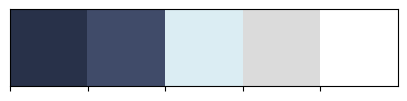

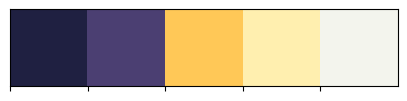

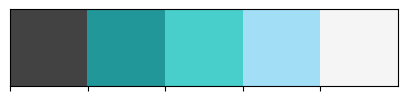

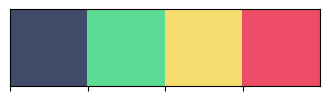

In [307]:
# Colors 1
colors = ["#283149", "#404B69", "#DBEDF3", "#DBDBDB", "#FFFFFF"]
colorsInv = ["#FFFFFF", "#DBDBDB", "#DBEDF3", "#404B69", "#283149"]
palette1 = sns.color_palette(colors)

# Colors 2
colors2 = ["#1F2041", "#4B3F72", "#FFC857", "#FFEFAF", "#F3F4ED"]
colorsInv2 = ["#F3F4ED", "#FFEFAF", "#FFC857", "#4B3F72", "#1F2041"]
palette2 = sns.color_palette(colors2)

# Colors 3
colors3 = ["#424242", "#229799", "#48CFCB", "#A2DFF7", "#F5F5F5"]  
colorsInv3 = ["#229799", "#48CFCB", "#A2DFF7", "#F5F5F5", "#A2DFF7", "#48CFCB", "#229799"]
palette3 = sns.color_palette(colors3)

# Colors 4
colors4 = ['#404B69', '#5CDB95', '#F7DC6F', '#ED4C67']
colorsInv4 = ['#ED4C67', '#F7DC6F', '#5CDB95', '#404B69']
palette4 = sns.color_palette(colors4)

cmap = matplotlib.colors.ListedColormap(colorsInv)
cmap2 = matplotlib.colors.ListedColormap(colorsInv2)
cmap3 = matplotlib.colors.ListedColormap(colorsInv3)

sns.palplot(sns.color_palette(colors))

sns.palplot(sns.color_palette(colors2))

sns.palplot(sns.color_palette(colors3))

sns.palplot(sns.color_palette(colors4))

pd.set_option('display.max_columns', 40)

# Data Dictionary

|     **Variable**    | **Descripción** | **Tipo de dato** | **Información Adicional** |
|---------------------|-------------|--------------|-----------------------|
| *FECHA_CORTE*       | Día que se generó el dataset | Numérico  | Formato: AAAAMMDD |
| *ID_PERSONA*        | Código único de identificación de cada afiliado del SNP, anonimizado.   | Numérico   |  |
| *SEXO*              | Sexo del afiliado   | Numérico   | 0: Femenino<br>1: Masculino|
| *FECHA_NACI*        | Fecha de nacimiento del asegurado. Si a partir de la fecha de nacimiento se calcula edades superiores a los 110 años o inferiores a 15 años, estos casos son considerados como registros sin información.   | Numérico   | Formato: AAAAMMDD |
| *EDAD*              | Edad (en años calendario) del afiliado   | Numérico   | |
| *R_EDAD*            | Rango de edad (en años) del afiliado   | Numérico   | 1: Hasta 24 años<br>2: 25 a 34 años<br>3: 35 a 44 años<br>4: 45 a 54 años<br>5: 55 a 64 años<br>6: 65 a más años |
| *ESTCIVIL*          | Estado civil del afiliado   | Numérico   | 1: Soltero<br>2: Casado<br>3: Viudo<br>4: Divorciado |
| *DEPARTAMENTO*      | Departamento de residencia del afiliado  | Numérico   | 01: Amazonas<br>02: Ancash<br>03: Apurímac<br>04: Arequipa<br>05: Ayacucho<br>06: Cajamarca<br>07: Cusco<br>08: Hucancavelica<br>09: Huánuco<br>10: Ica<br>11: Junín<br>12: La Libertad<br>13: Lambayeque<br>14: Lima<br>15: Loreto<br>16: Madre de Dios<br>17: Moquegua<br>18: Pasco<br>19: Piura<br>20: Puno<br>21: San Martín<br>22: Tacna<br>23: Tumbes<br>24: Callao<br>25: Ucayali<br>26: Extranjero |
| *APORTANTE*         | Indicador si el afiliado declaró aporte en el último mes   | Numérico   | 0: No<br>1: Sí |
| *TIPO_AFIL*         | Tipo de afiliado según categoría, en el último mes   | Numérico   | 1: Obligatorio<br>2: Facultativo<br>3: Libre desafiliación |
| *TIPO_DEP*          | Tipo de afiliado según dependencia, en el último mes   | Numérico   | 1: Dependiente<br>2: Independiente |
| *TIPO_TRABAJADOR*   | Tipo de trabajo que realizó el afiliado en el últimos mes   | Numérico   | El detalle se encuentra en el anexo 1 |
| *TIPO_EMPLEO*       | Tipo de sector en el que labora el afiliado en el último mes   | Numérico   | 0: Privado<br>1: Público |
| *APORTE*            | Monto del último aporte declarado del afiliado. Expresada en moneda peruana llamada sol.   | Numérico   | Con dos decimales, ejemplo: 1234.56 |
| *REMUNERACION*      | Remuneración asociada al último aporte declarado por el afiliado. Expresada en moneda peruana llamada sol.   | Numérico   | Con dos decimales, ejemplo: 1234.56 |
| *PRIMER_PERIODO*    | Primer periodo de aporte declarado del afiliado durante el periodo SUNAT | Numérico   | Formato: AAAAMM |
| *ULTIMO_PERIODO*    | Último periodo de aporte declarado del afiliado drurante el periodo SUNAT | Numérico   | Formato: AAAAMM |
| *NRO_APORTES*       | Número de meses de aportes declarados por el afiliados durante el periodo SUNAT | Numérico   |  |
| *MONTO_APORTES*     | Suma de aportes declarados por el afiliados en el periodo SUNAT. Expresada en moneda peruana llamada sol.  | Numérico   | Con dos decimales, ejemplo: 1234.56 |

# Load Dataset

In [308]:
snp = pd.read_csv("../data/Afiliados_SNP_tipo_empleo_2023_vff.csv")

In [309]:
snp = snp.set_index('id_persona')

In [310]:
snp = snp.drop(['fecha_corte', 'fecha_naci'], axis = 1)

# EDA

## Inspect Data

In [311]:
snp.head(5)

,sexo,edad,r_edad,estcivil,departamento,aportante,tipo_afil,tipo_dep,tipo_trabajador,tipo_empleo,aporte,remuneracion,primer_periodo,ultimo_periodo,nro_aportes,monto_aportes
id_persona,,,,,,,,,,,,,,,,
000000002650789200,NaN,70.0,6.0,NaN,NaN,0,1.0,1.0,21.0,0,52.0,400.00000,199908.0,199908.0,1,52.0
000000017645876200,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,21.0,0,45.0,346.15384,199708.0,199708.0,1,45.0
000000022697235200,NaN,NaN,NaN,NaN,NaN,0,2.0,2.0,53.0,0,111.0,853.84613,199801.0,199910.0,6,666.0
000000075816995200,NaN,NaN,NaN,NaN,NaN,0,2.0,2.0,34.0,0,46.0,353.84616,199909.0,199909.0,1,46.0
000000085520934200,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,21.0,0,NaN,NaN,199908.0,199908.0,1,NaN


In [312]:
snp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4660438 entries, 000000002650789200 to 9ZB310718702
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   sexo             float64
 1   edad             float64
 2   r_edad           float64
 3   estcivil         float64
 4   departamento     float64
 5   aportante        int64  
 6   tipo_afil        float64
 7   tipo_dep         float64
 8   tipo_trabajador  float64
 9   tipo_empleo      int64  
 10  aporte           float64
 11  remuneracion     float64
 12  primer_periodo   float64
 13  ultimo_periodo   float64
 14  nro_aportes      int64  
 15  monto_aportes    float64
dtypes: float64(13), int64(3)
memory usage: 604.5+ MB


In [313]:
snp.isnull().sum()

sexo                 35551
edad                  4209
r_edad                4209
estcivil           1829792
departamento         28697
aportante                0
tipo_afil            31920
tipo_dep             31920
tipo_trabajador     208376
tipo_empleo              0
aporte              351769
remuneracion        351769
primer_periodo         986
ultimo_periodo         585
nro_aportes              0
monto_aportes        47392
dtype: int64

In [314]:
snp.index.duplicated().sum()

0

In [315]:
rate_nulls = (snp.isnull().sum() / snp.shape[0]) * 100 # Porcentaje de nulos con respecto al total de registro para cada atributo
rate_nulls

sexo                0.762825
edad                0.090313
r_edad              0.090313
estcivil           39.262232
departamento        0.615758
aportante           0.000000
tipo_afil           0.684914
tipo_dep            0.684914
tipo_trabajador     4.471168
tipo_empleo         0.000000
aporte              7.547982
remuneracion        7.547982
primer_periodo      0.021157
ultimo_periodo      0.012552
nro_aportes         0.000000
monto_aportes       1.016900
dtype: float64

In [316]:
del_columns_1_percent = rate_nulls < 1.0

## Descriptive Analysis

In [12]:
snp.describe().T

,count,mean,std,min,25%,50%,75%,max
sexo,4624887.0,0.582132,0.493208,0.000000,0.000000,1.00,1.00000,1.0
edad,4656229.0,41.873262,13.532843,15.000000,31.000000,40.00,51.00000,110.0
r_edad,4656229.0,3.218396,1.342215,1.000000,2.000000,3.00,4.00000,6.0
estcivil,2830646.0,1.201103,0.460513,1.000000,1.000000,1.00,1.00000,4.0
departamento,4631741.0,12.314257,5.670075,1.000000,8.000000,14.00,14.00000,25.0
aportante,4660438.0,0.294542,0.455837,0.000000,0.000000,0.00,1.00000,1.0
tipo_afil,4628518.0,1.022029,0.147636,1.000000,1.000000,1.00,1.00000,3.0
tipo_dep,4628518.0,1.021776,0.145952,1.000000,1.000000,1.00,1.00000,2.0
tipo_trabajador,4452062.0,33.955609,23.475110,19.000000,20.000000,21.00,32.00000,98.0
tipo_empleo,4660438.0,0.253974,0.435283,0.000000,0.000000,0.00,1.00000,1.0


- El 58% de los afiliados son hombres
- El 29% de los afiliados declaró el aporte realizado en el último mes.
- La cuarta parte de los afiliados (25%) trabajó en el sector público durante el último mes.
- En promedio se declararon 50 aportes durante el promedio de SUNAT.

## Data Visualization

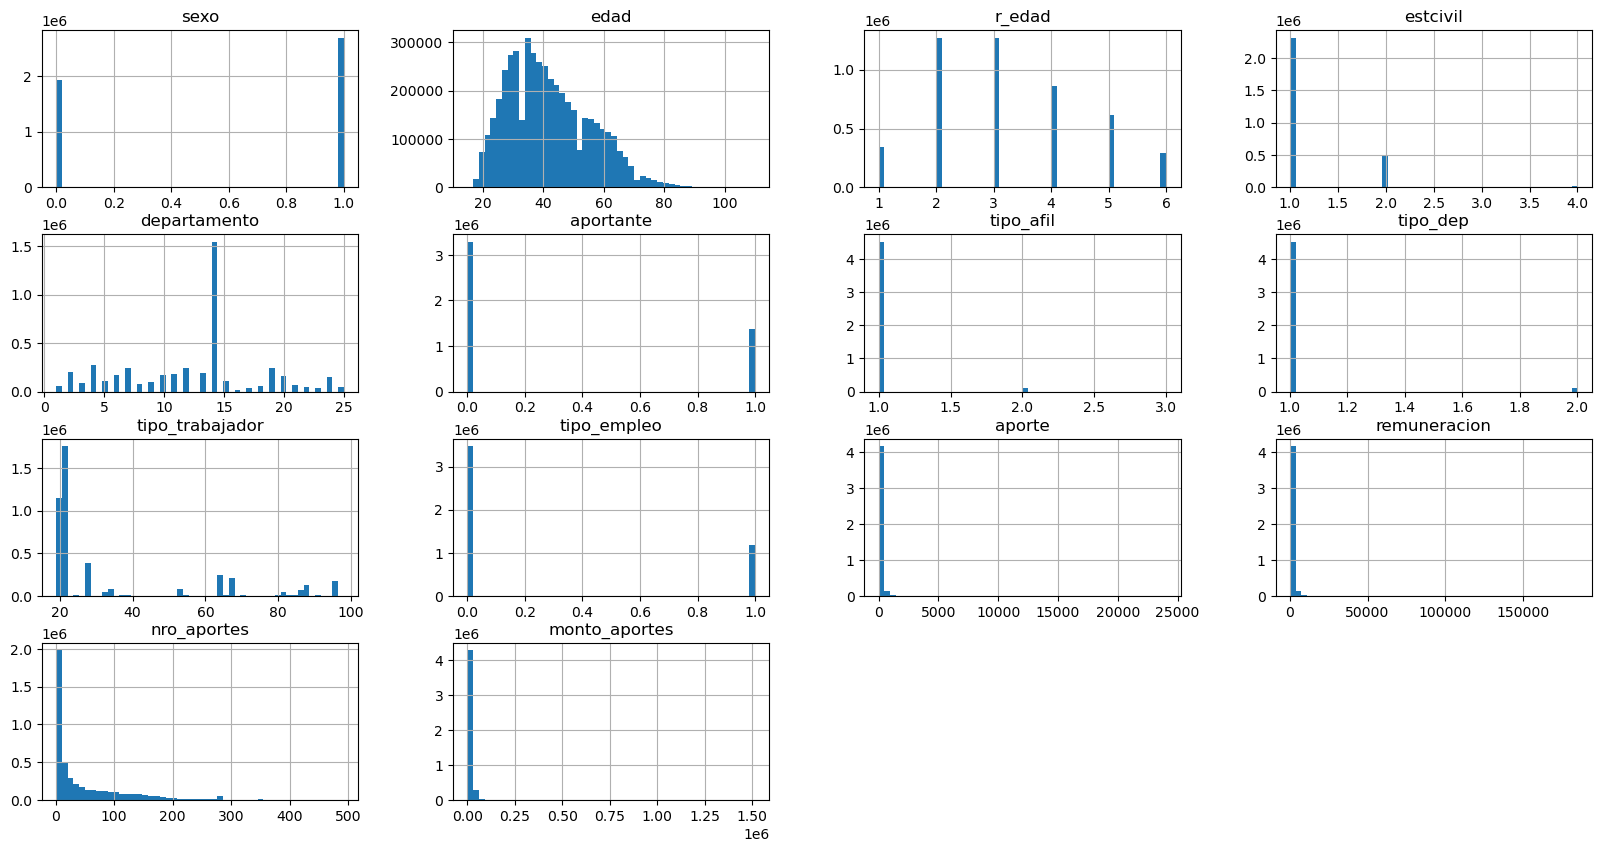

In [13]:
snp.drop(['ultimo_periodo', 'primer_periodo'], axis = 1).hist(bins = 50, figsize = (20, 10))
plt.show()

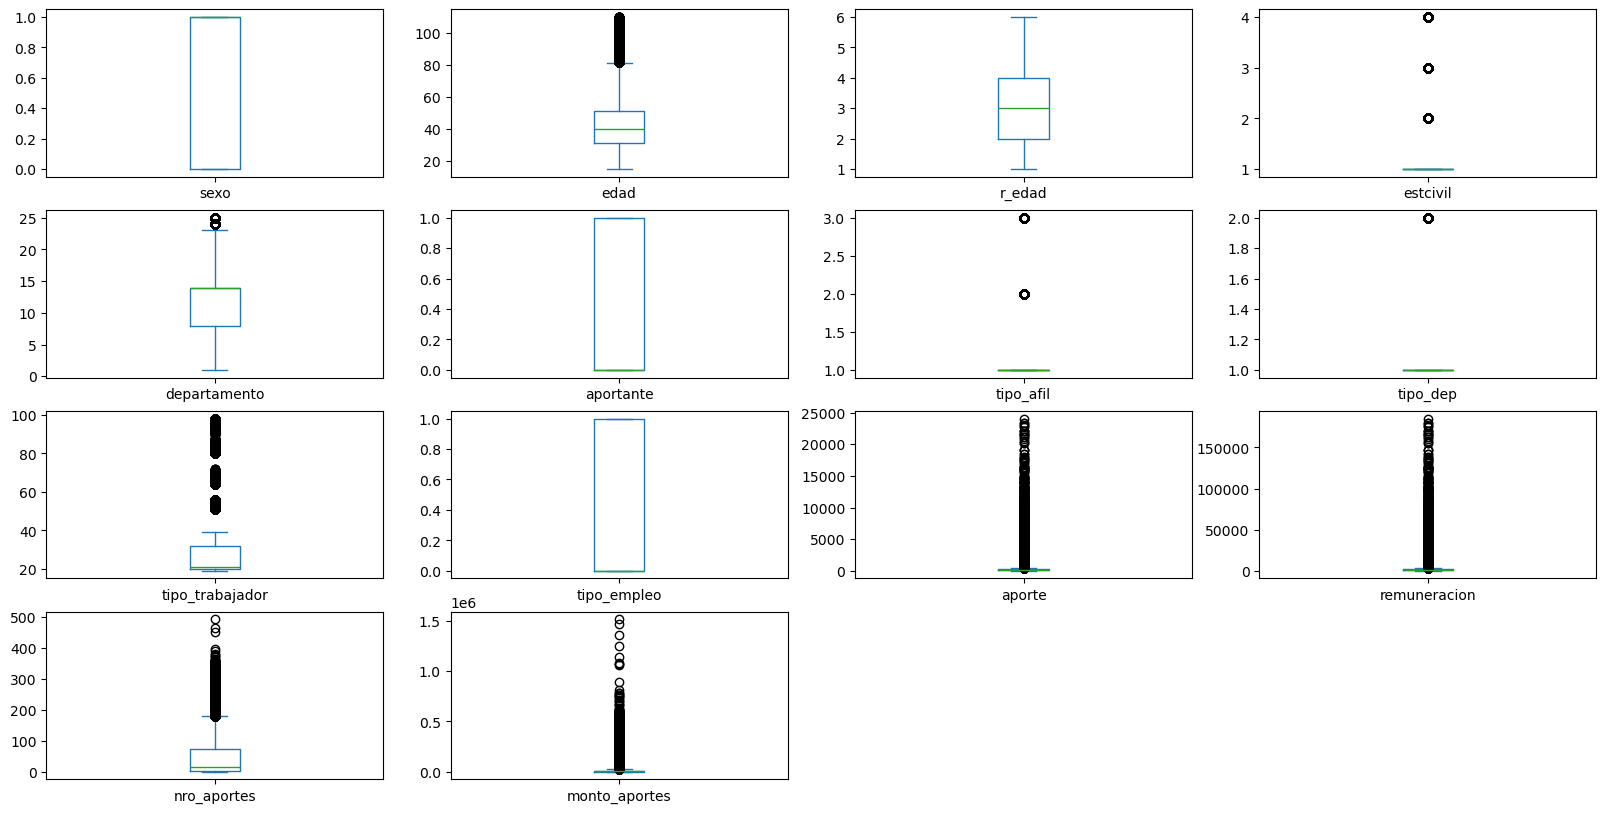

In [14]:
snp.drop(['ultimo_periodo', 'primer_periodo'], axis = 1).plot(kind = 'box', subplots = True, layout = (4, 4),figsize = (20, 10))
plt.show()

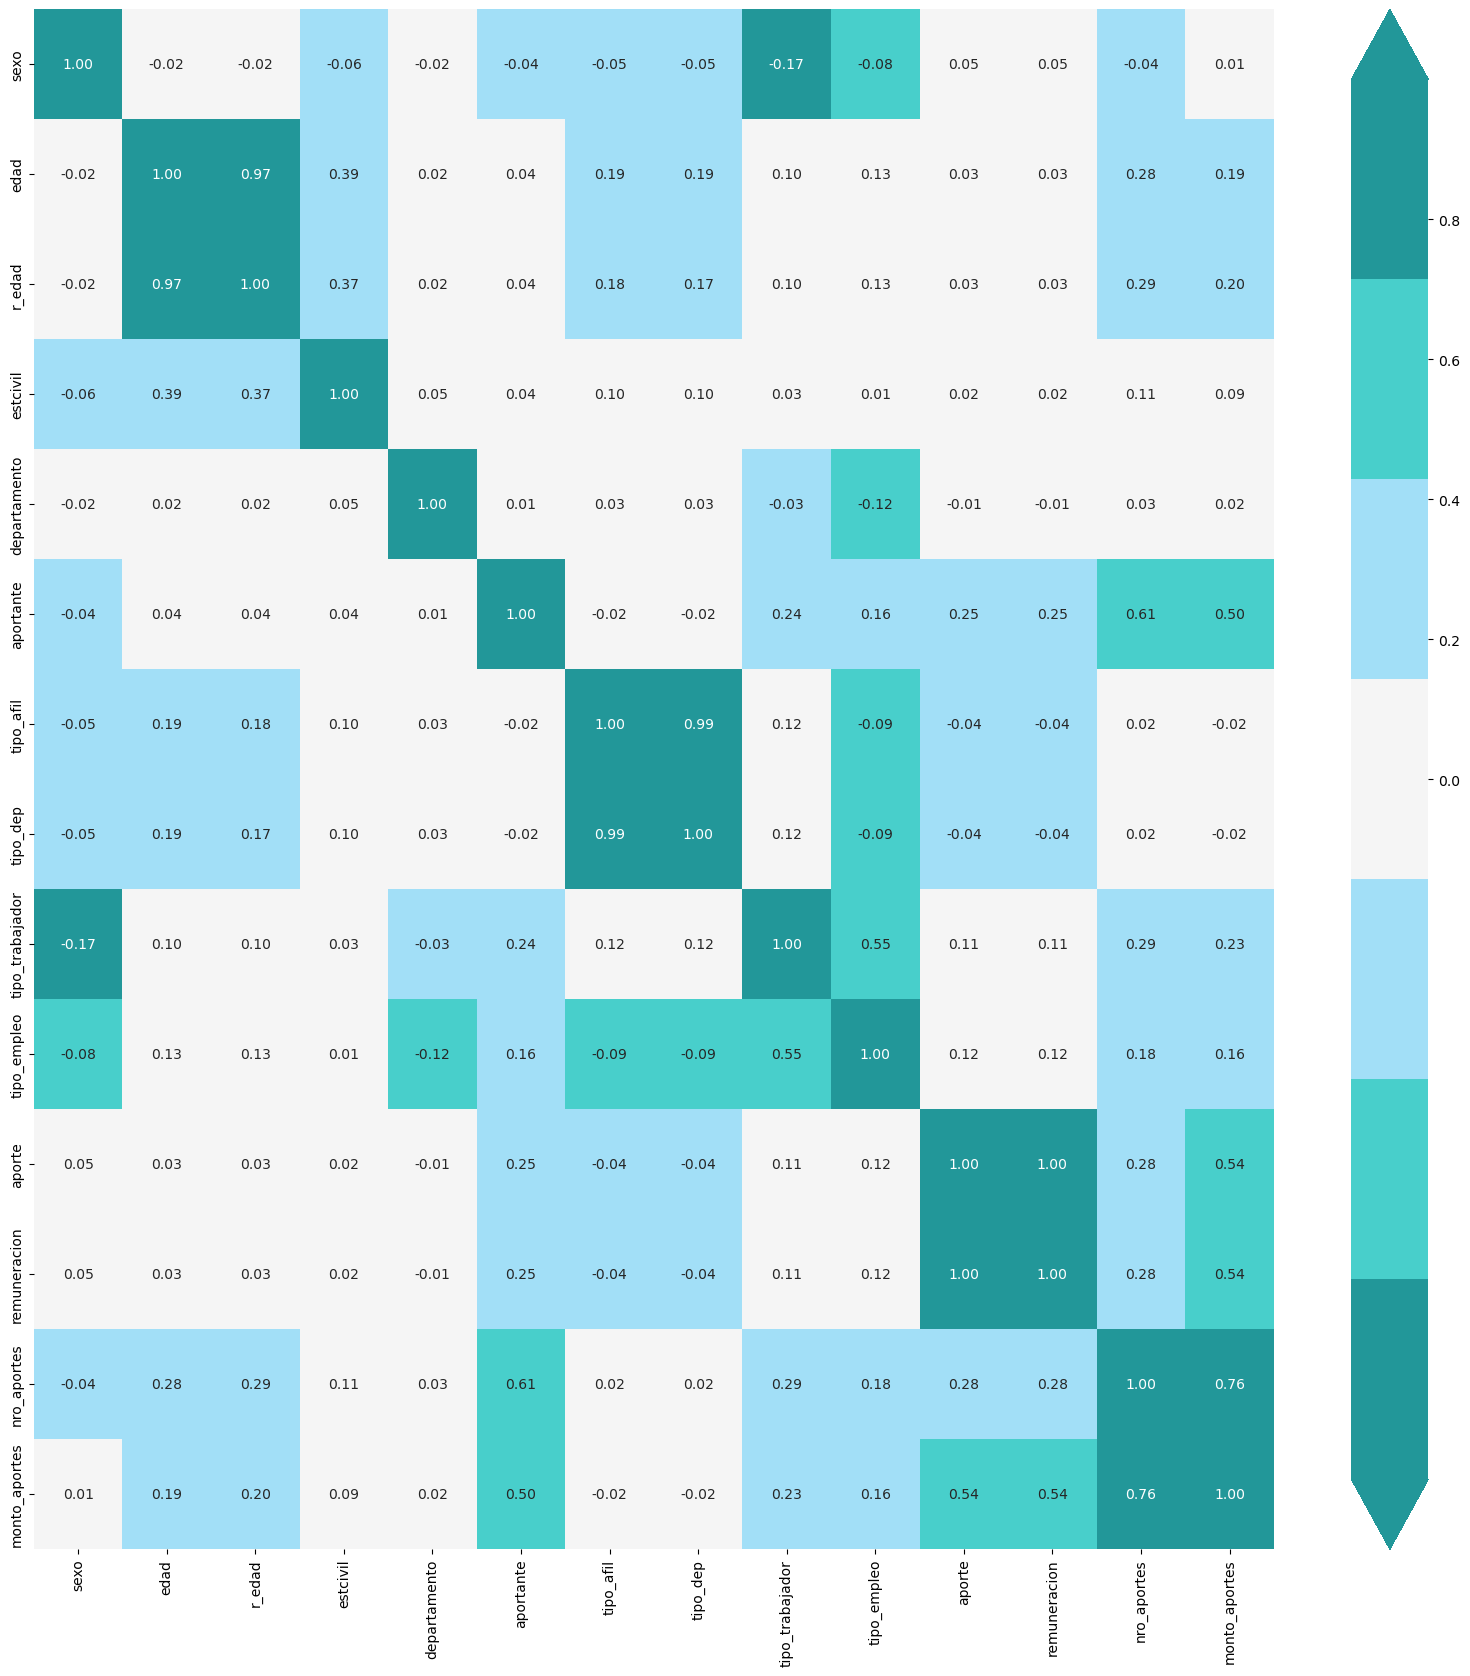

In [15]:
plt.figure(figsize=(20, 20))
corr = snp.drop(['ultimo_periodo', 'primer_periodo'], axis = 1).corr()
sns.heatmap(
    corr,
    annot=True,
    cmap=cmap3,
    fmt='.2f',
    cbar_kws={'extend': 'both'},
    norm=mcolors.TwoSlopeNorm(vmin=corr.min().min(), vcenter=0, vmax=corr.max().max())
)
plt.show()

# Preprocessing

In [318]:
df = snp.copy()

In [319]:
# eliminamos las filas vacias menores a 1%
df = df.dropna(subset = df.columns[del_columns_1_percent])

In [320]:
df['ultimo_periodo'] = pd.to_datetime(df['ultimo_periodo'], format = '%Y%m')
df['primer_periodo'] = pd.to_datetime(df['primer_periodo'], format = '%Y%m')

In [321]:
df['tiempo_aporte_mes'] = (df['ultimo_periodo'] - df['primer_periodo']).dt.days / 30

In [322]:
# eliminamos las columnas menos informativas
df = df.drop(['ultimo_periodo', 'primer_periodo'], axis = 1)

In [323]:
cat_columns = ['estcivil', 'departamento', 'tipo_afil', 
               'tipo_dep', 'tipo_trabajador']

In [324]:
num_columns = ['sexo', 'edad', 'r_edad', 'nro_aportes']

In [325]:
df[num_columns] = df[num_columns].astype(np.int64)

In [326]:
df[cat_columns] = df[cat_columns].astype(object)

In [327]:
tasa_nulos_departamento = ((df[['departamento', 'estcivil']].groupby('departamento')['estcivil'].apply(lambda x: x.isnull().sum())) / df['departamento'].value_counts()) * 100
tasa_nulos_departamento

departamento
1.0     46.754955
2.0     38.838558
3.0     45.985155
4.0     34.184119
5.0     44.140632
6.0     43.884351
7.0     41.287348
8.0     43.705093
9.0     47.453399
10.0    39.349251
11.0    39.733751
12.0    40.710501
13.0    39.413158
14.0    34.527589
15.0    59.458702
16.0    41.600835
17.0    32.931829
18.0    36.767058
19.0    41.491942
20.0    40.321144
21.0    49.347857
22.0    35.044138
23.0    37.943312
24.0    32.475047
25.0    48.414020
dtype: float64

In [328]:
df = df.drop('estcivil', axis = 1)

In [329]:
df = df.dropna()

In [19]:
mode_pipeline = Pipeline([
    ('imputer_mode', SimpleImputer(strategy = 'most_fequent')),
    ('standard_scaler', StandardScaler())
])

In [20]:
default_pipeline = Pipeline([
    ('imputer_mean', SimpleImputer(strategy = 'mean')),
    ('standard_scaler', StandardScaler())
])

In [21]:
knn_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors = 5)),
    ('standard_scaler', StandardScaler())
])

In [457]:
preprocessing = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(sparse_output = False), ["departamento", "tipo_afil", "tipo_dep", "tipo_trabajador"]),
    ("standard_scaler", StandardScaler(), ["edad", "aporte", "remuneracion", "nro_aportes", "tiempo_aporte_mes"])
], remainder= 'passthrough')

# Vizualization

In [340]:
viz = df.copy()

In [341]:
departamentos = { 1: "Amazonas", 2: "Ancash", 3: "Apurímac", 4: "Arequipa", 5: "Ayacucho", 6: "Cajamarca", 7: "Cusco", 8: "Huancavelica",
                 9: "Huánuco", 10: "Ica", 11: "Junín", 12: "La Libertad", 13: "Lambayeque", 14: "Lima", 15: "Loreto", 16: "Madre de Dios",
                 17: "Moquegua", 18: "Pasco", 19: "Piura", 20: "Puno", 21: "San Martín", 22: "Tacna", 23: "Tumbes", 24: "Callao", 25: "Ucayali"}

In [342]:
r_edad = { 1: "Hasta 24 años", 2: "25 a 34 años", 3: "35 a 44 años",
          4: "45 a 54 años", 5: "55 a 64 años", 6: "65 a más años"}

In [343]:
sexo = {0: "Femenino", 1: "Masculino"}

In [344]:
viz['departamento'].replace(departamentos, inplace = True)
viz['r_edad'].replace(r_edad, inplace = True)
viz['sexo'].replace(sexo, inplace = True)

In [345]:
afiliados_sexo_departamento = viz[['departamento', 'sexo']].groupby(['departamento', 'sexo'])['sexo'].count().reset_index(name = 'count')

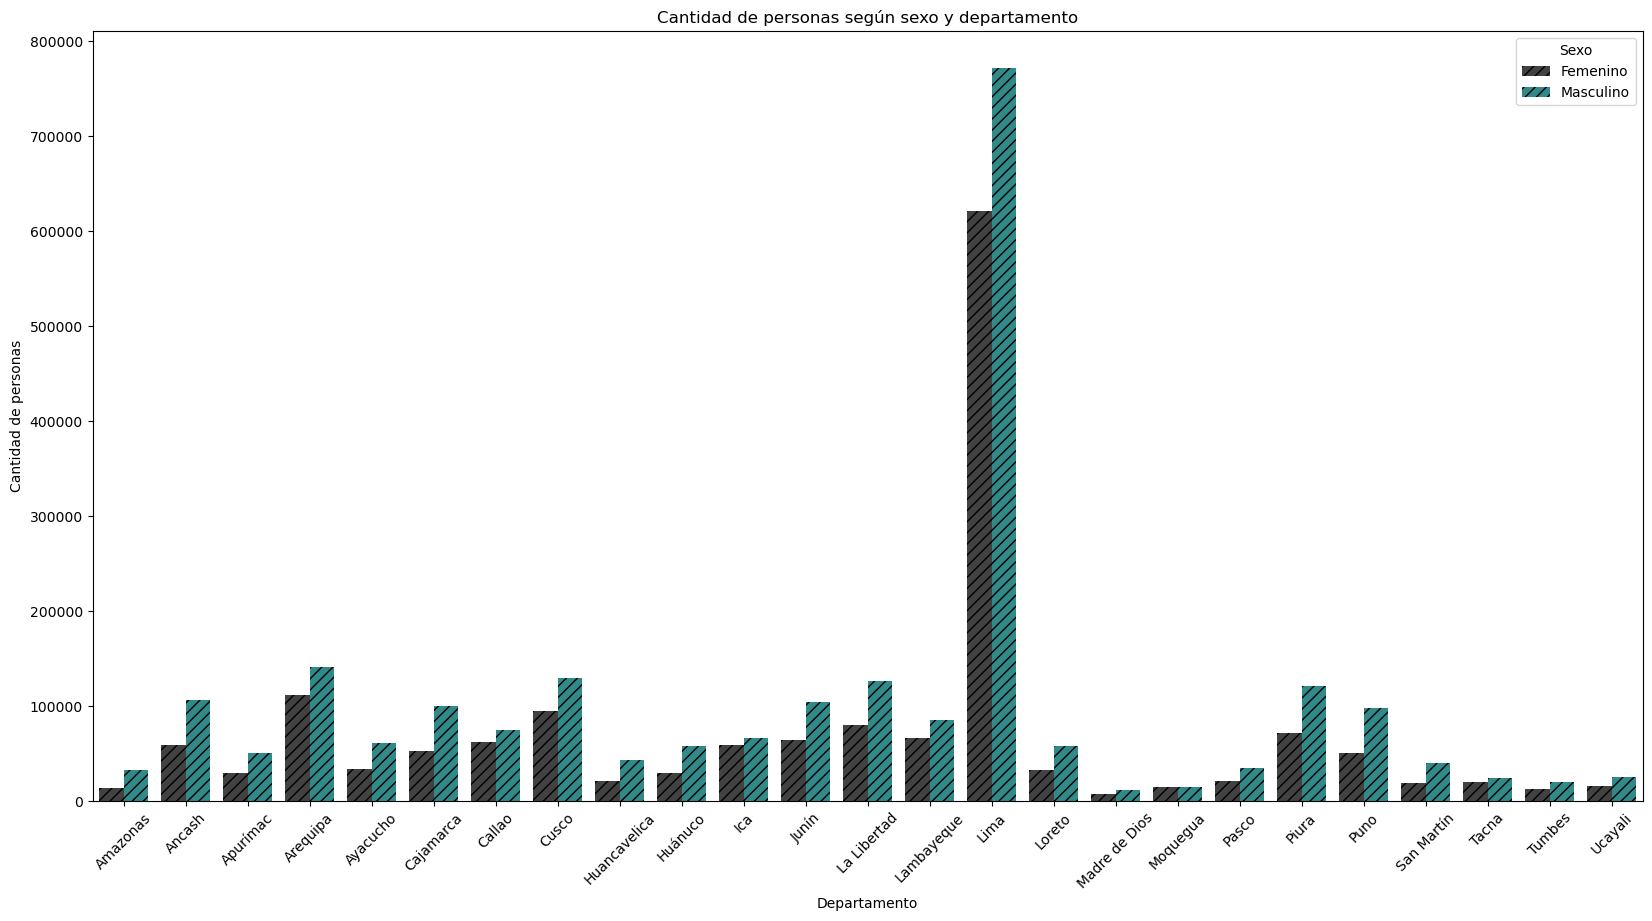

In [346]:
plt.figure(figsize=(20, 10))
sns.barplot(data = afiliados_sexo_departamento, x='departamento', y='count', hue='sexo', palette= palette3, hatch = '///')

plt.title('Cantidad de personas según sexo y departamento')
plt.xlabel('Departamento')
plt.ylabel('Cantidad de personas')

plt.xticks(rotation = 45)
plt.legend(title='Sexo')
plt.show()

In [347]:
acum_aporte_departamento = viz[['departamento', 'monto_aportes']].groupby('departamento')['monto_aportes'].sum().reset_index()

In [348]:
acum_aporte_departamento['h'] = acum_aporte_departamento['monto_aportes'] / sum(acum_aporte_departamento['monto_aportes'])

In [349]:
acum_aporte_departamento.sort_values(by = 'h', ascending = False, inplace = True)

In [350]:
acum_aporte_departamento['H'] = np.cumsum(acum_aporte_departamento['h'])

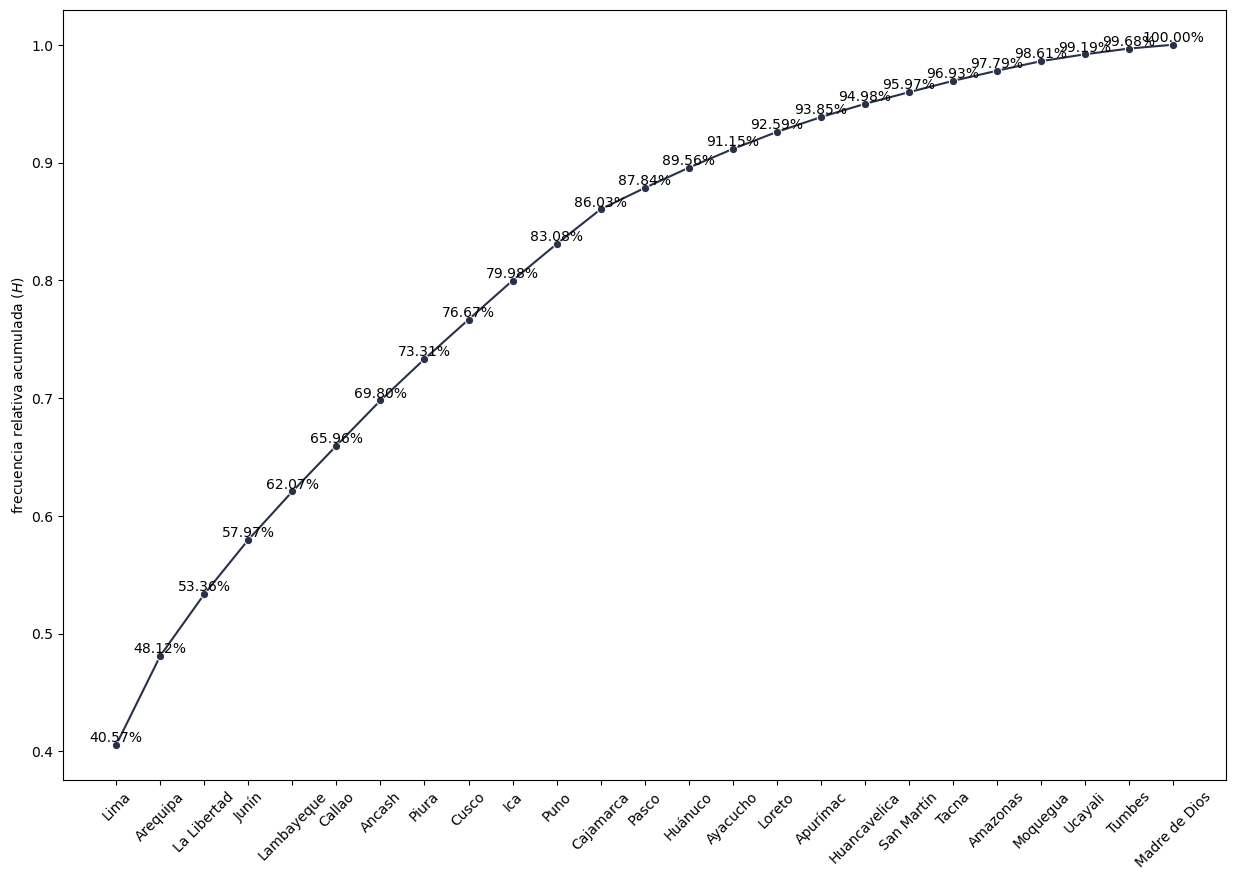

In [351]:
plt.figure(figsize = (15, 10))

sns.lineplot(data = acum_aporte_departamento, x = 'departamento', y = 'H', color = colors[0], marker = 'o')

for i in range(acum_aporte_departamento.shape[0]):
    plt.text(i, acum_aporte_departamento['H'].iloc[i], f'{acum_aporte_departamento["H"].iloc[i] * 100:.2f}%', ha = 'center', va = 'bottom')

plt.ylabel("frecuencia relativa acumulada $(H)$")
plt.xlabel("")

plt.xticks(rotation = 45)
plt.show()

In [352]:
acum_tiempo_aporte_departamento = viz[['departamento', 'tiempo_aporte_mes']].groupby('departamento')['tiempo_aporte_mes'].sum().reset_index()

In [353]:
acum_tiempo_aporte_departamento['h'] = acum_tiempo_aporte_departamento['tiempo_aporte_mes'] / sum(acum_tiempo_aporte_departamento['tiempo_aporte_mes'])

In [354]:
acum_tiempo_aporte_departamento.sort_values(by = 'h', ascending = False, inplace = True)

In [355]:
acum_tiempo_aporte_departamento['H'] = np.cumsum(acum_tiempo_aporte_departamento['h'])

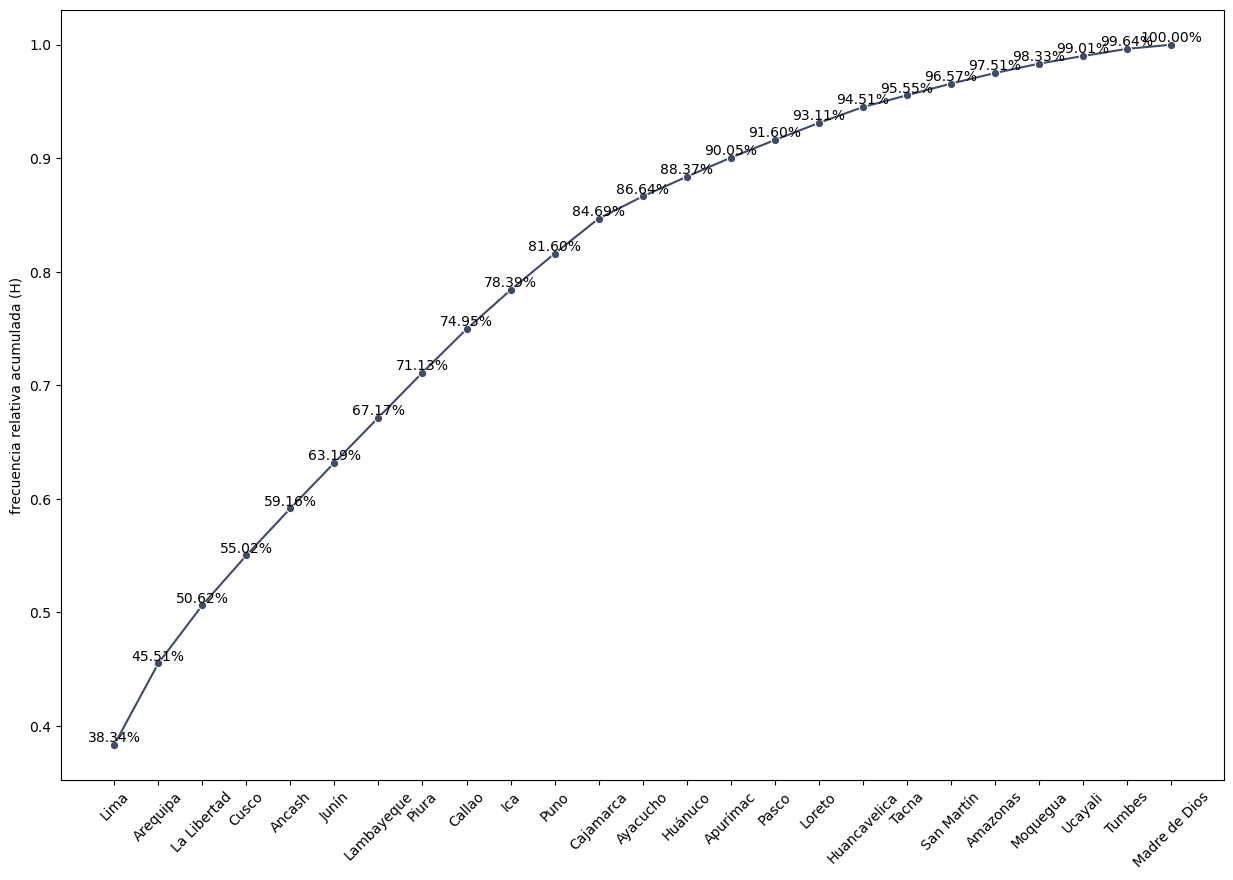

In [356]:
plt.figure(figsize = (15, 10))

sns.lineplot(data = acum_tiempo_aporte_departamento, x = 'departamento', y = 'H', color = colors[1], marker = 'o')

for i in range(acum_tiempo_aporte_departamento.shape[0]):
    plt.text(i, acum_tiempo_aporte_departamento['H'].iloc[i], f'{acum_tiempo_aporte_departamento["H"].iloc[i] * 100:.2f}%', ha = 'center', va = 'bottom')

plt.ylabel("frecuencia relativa acumulada (H)")
plt.xlabel("")
plt.xticks(rotation = 45)
plt.show()

In [357]:
acum_aporte_trabajo = viz[['tipo_trabajador', 'monto_aportes']].groupby('tipo_trabajador')['monto_aportes'].sum().reset_index()

In [358]:
acum_aporte_trabajo['tipo_trabajador'] = acum_aporte_trabajo['tipo_trabajador'].astype(str)

In [359]:
acum_aporte_trabajo['h'] = acum_aporte_trabajo['monto_aportes'] / sum(acum_aporte_trabajo['monto_aportes'])

In [360]:
acum_aporte_trabajo.sort_values(by = 'h', ascending = False, inplace = True)

In [361]:
acum_aporte_trabajo['H'] = np.cumsum(acum_aporte_trabajo['h'])

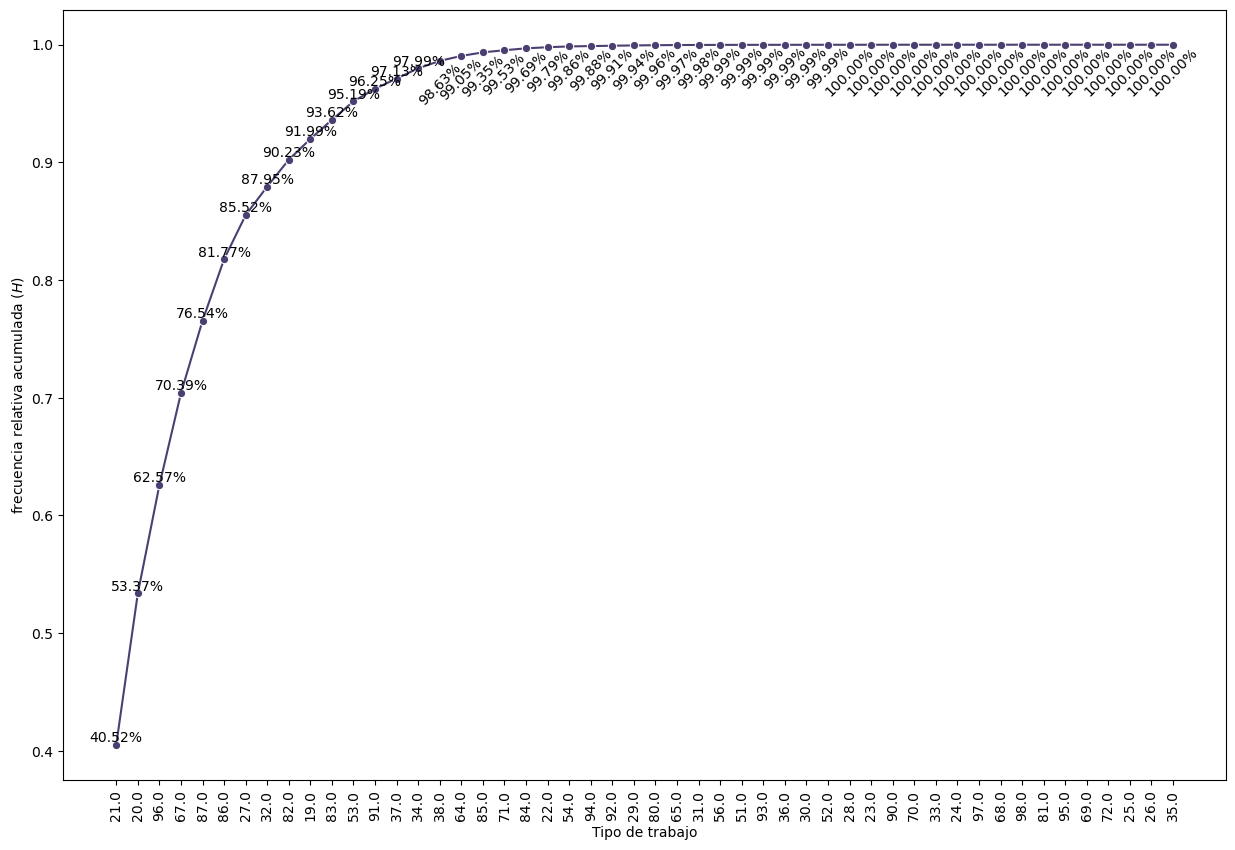

In [362]:
plt.figure(figsize = (15, 10))

sns.lineplot(data = acum_aporte_trabajo, x = 'tipo_trabajador', y = 'H', color = colors2[1], marker = 'o')

for i in range(acum_aporte_trabajo.shape[0]):
    if i < 15:
        plt.text(i, acum_aporte_trabajo['H'].iloc[i], f"{acum_aporte_trabajo['H'].iloc[i] * 100:.2f}%", ha = 'center', va = 'bottom')
    else:
        plt.text(i, acum_aporte_trabajo['H'].iloc[i], f"{acum_aporte_trabajo['H'].iloc[i] * 100:.2f}%", ha = 'center', va = 'top', rotation = 45)

plt.ylabel("frecuencia relativa acumulada $(H)$")
plt.xlabel("Tipo de trabajo")
plt.xticks(rotation = 90)
plt.show()

In [370]:
acum_redad_dep_aporte = viz[['r_edad', 'departamento', 'monto_aportes']].groupby(['departamento', 'r_edad'])['monto_aportes'].sum().reset_index()

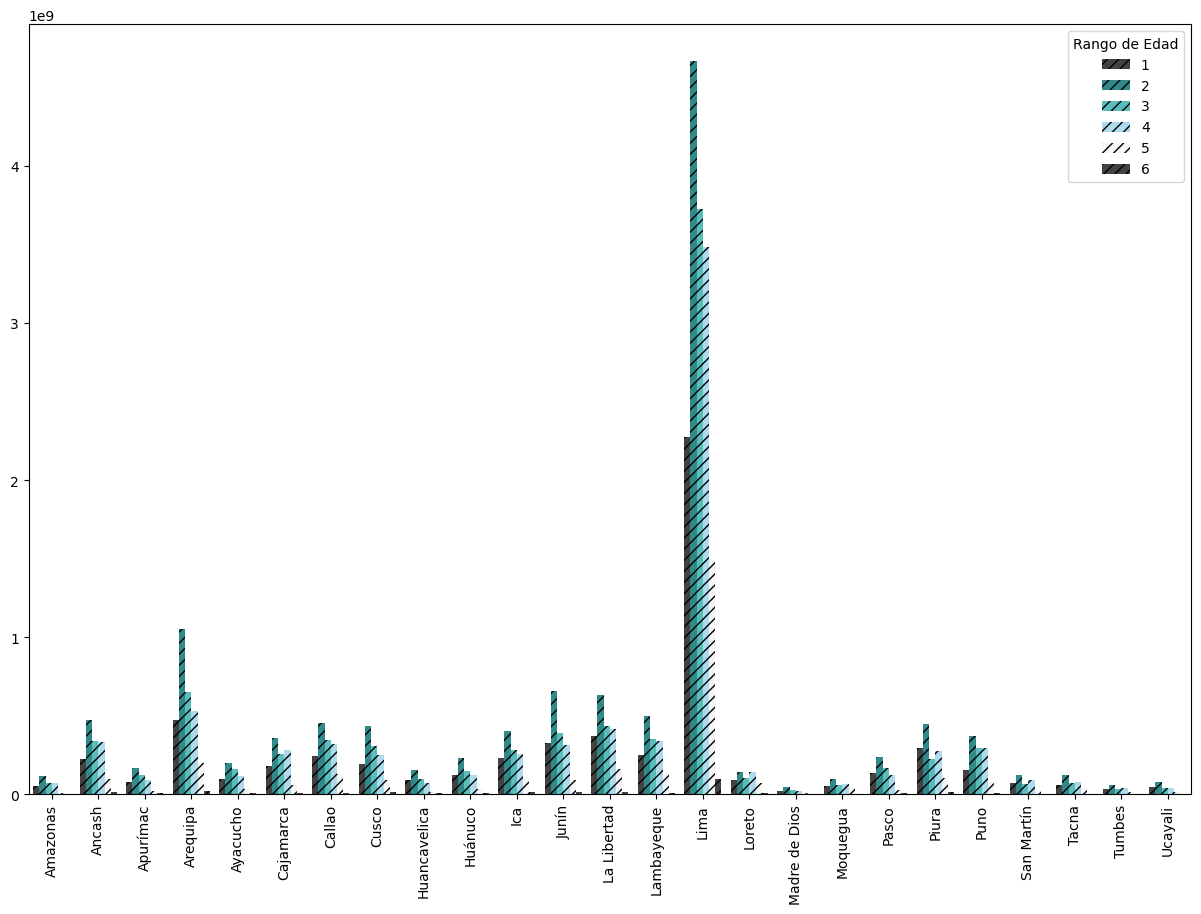

In [371]:
plt.figure(figsize = (15, 10))

barplot = sns.barplot(data = acum_redad_dep_aporte, x = 'departamento', y = 'monto_aportes', hue = 'r_edad', hatch = '///', palette= palette3)

handles, _ = barplot.get_legend_handles_labels()
barplot.legend(handles, r_edad, title = 'Rango de Edad')

plt.ylabel("")
plt.xlabel("")
plt.xticks(rotation = 90)
plt.show()

In [372]:
acum_redad_aportes = acum_redad_dep_aporte[['r_edad', 'monto_aportes']].groupby('r_edad')['monto_aportes'].sum().reset_index()

In [391]:
count_redad = viz[['r_edad']].groupby('r_edad')['r_edad'].count().reset_index(name = 'count')

In [373]:
acum_redad_aportes['h'] = acum_redad_aportes['monto_aportes'] / sum(acum_redad_aportes['monto_aportes'])
acum_redad_aportes.sort_values(by = 'h', ascending = False, inplace = True)

In [374]:
acum_redad_aportes['H'] = np.cumsum(acum_redad_aportes['h'])

In [394]:
merge_count_redad_aportes = pd.merge(acum_redad_aportes, count_redad, on = 'r_edad')

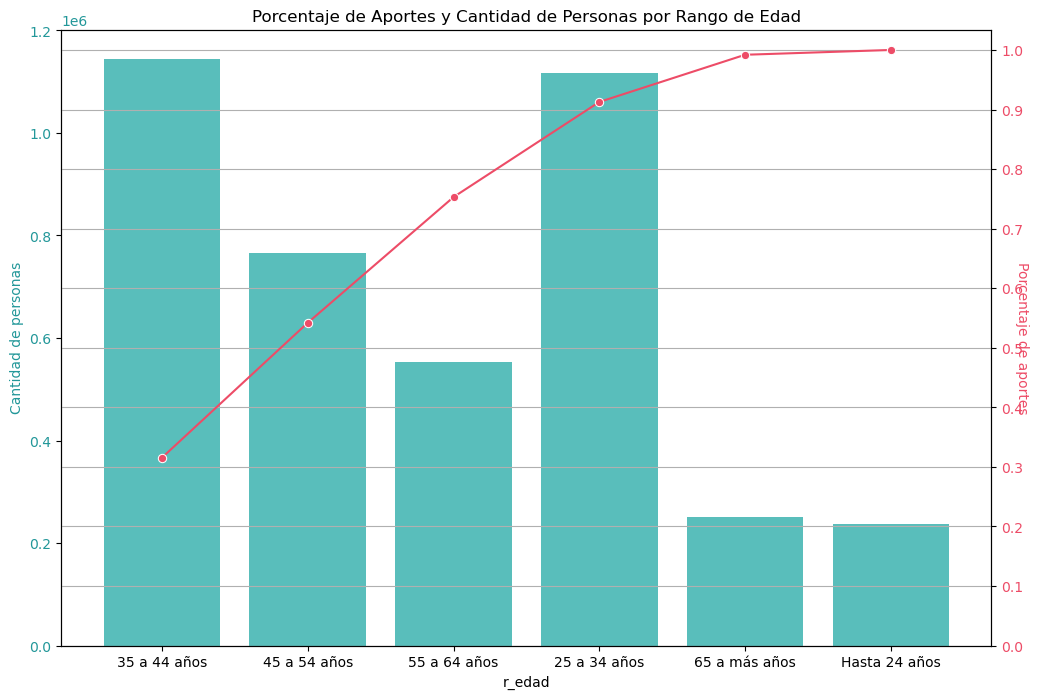

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(data=merge_count_redad_aportes, x='r_edad', y='count', ax = ax1, color = colors3[2])
ax1.set_ylabel('Cantidad de personas', color = colors3[1])
ax1.tick_params(axis='y', labelcolor = colors3[1])

ax2 = ax1.twinx()

sns.lineplot(data=merge_count_redad_aportes, x='r_edad', y='H', color= colors4[3], marker='o', ax=ax2)
ax2.set_ylabel('Porcentaje de aportes', color = colors4[3], rotation = 270)
ax2.tick_params(axis='y', labelcolor = colors4[3])
ax2.set_yticks(np.linspace(0.0, 1.0, 11))
ax2.grid(True, which='both', zorder=0)

plt.title('Porcentaje de Aportes y Cantidad de Personas por Rango de Edad')
plt.xlabel('Rango de Edad')
plt.xticks(rotation = 45)


plt.show()

# Models

In [69]:
X = df.drop('monto_aportes', axis = 1)
y = df['monto_aportes'].copy()

In [70]:
X = X[:1_000_000]
y = y[:1_000_000]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## random forest

In [63]:
model = TransformedTargetRegressor(RandomForestRegressor(random_state = 42),
                                   transformer = StandardScaler())

In [64]:
rf_reg = make_pipeline(
    preprocessing,
    model
)

In [48]:
rf_reg_score = -cross_val_score(rf_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
rf_reg_score.mean()

nan

In [50]:
rf_reg_score

array([45755091.49705824, 36623430.46665994,               nan,
       51361702.97889972, 40740749.69342043])

In [72]:
rf_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['departamento', 'tipo_afil',
                                                   'tipo_dep',
                                                   'tipo_trabajador']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['edad', 'aporte',
                                                   'remuneracion',
                                                   'nro_aportes',
                                                   'tiempo_aporte_mes'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42),
                                            transformer=StandardScaler()))])

In [75]:
y_pred = rf_reg.predict(X_test[:100])

In [76]:
mean_squared_error(y_test[:100], y_pred)

97845568.26528393

## Multi-Layer Perceptron

In [436]:
mlp_reg = TransformedTargetRegressor(MLPRegressor(hidden_layer_sizes = (30, 20, 10, 10), 
                                                  max_iter = 10),
                                     transformer = StandardScaler())

In [437]:
mlp_reg.fit(X_train, y_train)

TransformedTargetRegressor(regressor=MLPRegressor(hidden_layer_sizes=(30, 20,
                                                                      10, 10),
                                                  max_iter=10),
                           transformer=StandardScaler())

In [438]:
mlp_reg.predict(X_test[:5])

array([14846.43452845,   191.2450527 ,  -183.26402057,  2624.15757   ,
         755.26361023])

In [439]:
y_test[:5]

75721     13809.37
80184         57.0
19864        94.25
76699      1576.58
92991    635.23999
Name: remainder__monto_aportes, dtype: object